In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as mcolors
import numpy as np
import scipy as sp
from scipy.signal import find_peaks, argrelextrema
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.interpolate import interp1d
import os
from pathlib import Path
import scienceplots


# This script can be used to analyze raw emg data from the Delsys Trigno system


In [4]:
def load_gyro(file_path):
    # Skip the first rows containing metadata
    skip_rows = 0  # Adjust based on the exact number of metadata rows
    # Read the actual sensor data, assuming the delimiter is tab or spaces
    df = pd.read_csv(file_path, delimiter=',', skiprows=skip_rows, usecols=[0, 1, 2])
    # Rename the columns based on the file format
    df.columns = ['GYRO X (deg/s)', 'GYRO Y (deg/s)', 'GYRO Z (deg/s)']
    df = df.apply(pd.to_numeric, errors='coerce')

    # Remove columns with nan values
    df = df.dropna()
    return df

def load_acc(file_path):
    # Skip the first rows containing metadata
    skip_rows = 0  # Adjust based on the exact number of metadata rows
    # Read the actual sensor data, assuming the delimiter is tab or spaces
    df = pd.read_csv(file_path, delimiter=',', skiprows=skip_rows, usecols=[0, 1, 2])
    # Rename the columns based on the file format
    df.columns = ['ACC X (G)', 'ACC Y (G)', 'ACC Z (G)']
    df = df.apply(pd.to_numeric, errors='coerce')

    # Remove columns with nan values
    df = df.dropna()
    return df

def load_emg(file_path):
    # Skip the first rows containing metadata
    skip_rows = 0  # Adjust based on the exact number of metadata rows
    # Read the actual sensor data, assuming the delimiter is tab or spaces
    df = pd.read_csv(file_path, delimiter=',', skiprows=skip_rows, usecols=[0])
    # Rename the columns based on the file format
    df.columns = ['EMG 1 (mV)']
    df = df.apply(pd.to_numeric, errors='coerce')

    # Remove columns with nan values
    df = df.dropna()
    return df

def load_log(file_path):
    # Skip the first rows containing metadata
    skip_rows = 0  # Adjust based on the exact number of metadata rows
    # Read the actual sensor data, assuming the delimiter is tab or spaces
    df = pd.read_csv(file_path, delimiter=',', skiprows=skip_rows)
    # Rename the columns based on the file format
    # df.columns = ['Segment Start Index', 'Segment End Index', 'Start Time', 'End Time', 'Unassisted Mean']
    df.columns = ['Tag', 'Start Time', 'End Time', 'Score', 'Unassisted Mean', 'Segment Length', 'Unassisted']
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

def load_or(file_path):
    # Skip the first rows containing metadata
    skip_rows = 0  # Adjust based on the exact number of metadata rows
    # Read the actual sensor data, assuming the delimiter is tab or spaces
    df = pd.read_csv(file_path, delimiter=',', skiprows=skip_rows)
    # Rename the columns based on the file format
    df.columns = ['OR W', 'OR X', 'OR Y', 'OR Z']
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

def load(file_path):
    # Skip the first rows containing metadata
    skip_rows = 0  # Adjust based on the exact number of metadata rows
    # Read the actual sensor data, assuming the delimiter is tab or spaces
    df = pd.read_csv(file_path, delimiter=',', skiprows=skip_rows)
    # Rename the columns based on the file format
    # df.columns = ['1']
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

In [6]:
def apply_lowpass_filter(df: pd.DataFrame, cutoff_freq: float, sampling_freq: float, filter_order=4) -> pd.DataFrame:
    """
    Apply a low-pass filter to the first 7 columns of the given DataFrame.

    Parameters:
    - df: pandas.DataFrame with the data to be filtered.
    - cutoff_freq: The cutoff frequency for the low-pass filter (in Hz).
    - sampling_freq: The sampling frequency of the data (in Hz).
    - filter_order: The order of the Butterworth filter (default is 4).

    Returns:
    - df_filtered: DataFrame with the low-pass filtered values.
    """
    # Normalize the cutoff frequency with respect to Nyquist frequency
    nyquist_freq = sampling_freq / 2
    normalized_cutoff = cutoff_freq / nyquist_freq

    # Design a Butterworth low-pass filter
    b, a = sp.signal.butter(filter_order, normalized_cutoff, btype='low')

    # Create a copy of the DataFrame to hold the filtered data
    df_filtered = df.copy()

    # Apply the filter to data
    for col in df.columns:
        df_filtered[col] = sp.signal.filtfilt(b, a, df[col])

    return df_filtered


def filter_emg(unfiltered_df: pd.DataFrame, low_pass=4, sfreq=2000, high_band=20, low_band=450) -> pd.DataFrame:
    """ Filter EMG signals

    Args:
        unfiltered_df (pd.DataFrame): DataFrame containing the EMG data and time
        low_pass (int, optional): Low-pass cut off frequency. Defaults to 4.
        sfreq (int, optional): Sampling frequency. Defaults to 2000.
        high_band (int, optional): High-band frequency for bandpass filter. Defaults to 20.
        low_band (int, optional): Low-band frequency for bandpass filter. Defaults to 450.

    Returns:
        pd.DataFrame: filtered dataframe
    """
    emg_data = unfiltered_df.copy()

    # Normalize cut-off frequencies to sampling frequency
    high_band_normalized = high_band / (sfreq / 2)
    low_band_normalized = low_band / (sfreq / 2)
    low_pass_normalized = low_pass / (sfreq / 2)

    # Bandpass filter coefficients
    b1, a1 = sp.signal.butter(4, [high_band_normalized, low_band_normalized], btype='bandpass')

    # Lowpass filter coefficients
    b2, a2 = sp.signal.butter(4, low_pass_normalized, btype='lowpass')

    def process_emg(emg):
        # Handle NaNs: skip filtering for NaN segments
        if emg.isna().all():
            return emg  # Returns as is if all are NaNs

        # Correct mean for non-NaN values
        non_nan_emg = emg.dropna()
        emg_correctmean = non_nan_emg - non_nan_emg.mean()

        # Filter EMG: bandpass, rectify, lowpass for non-NaN values
        emg_filtered = sp.signal.filtfilt(b1, a1, emg_correctmean)
        emg_rectified = np.abs(emg_filtered)
        emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)

        # Construct the resulting series, placing NaNs back in their original positions
        result = pd.Series(index=emg.index, data=np.nan)
        result[emg.notna()] = emg_envelope

        return result

    # Apply processing to each column
    envelopes = emg_data.apply(process_emg, axis=0)
    env_freq = int(low_pass_normalized * sfreq)

    return envelopes, env_freq


In [7]:
def plot_data(imu_df, emg_df, or_df, file_path, start, end):
    filename = os.path.basename(file_path).replace('.csv', '')

    # filter the imu data
    imu_df = apply_lowpass_filter(imu_df, 1, 519)

    # Plotting
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

    # Subplot for angular accelerations (ACC X, ACC Y, ACC Z)
    ax1.plot(imu_df['Time (s)'], imu_df['ACC X (G)'], label='ACC X (G)')
    ax1.plot(imu_df['Time (s)'], imu_df['ACC Y (G)'], label='ACC Y (G)')
    ax1.plot(imu_df['Time (s)'], imu_df['ACC Z (G)'], label='ACC Z (G)')
    ax1.axvline(x=start, color='r', linestyle='--', label='Start')
    ax1.axvline(x=end, color='g', linestyle='--', label='End')
    ax1.set_ylabel('Angular Acceleration (G)')
    ax1.set_title('Angular Accelerations')
    ax1.legend()
    ax1.grid(True)

    # Subplot for angular velocities (GYRO X, GYRO Y, GYRO Z)
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO X (deg/s)'], label='GYRO X (deg/s)')
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO Y (deg/s)'], label='GYRO Y (deg/s)')
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO Z (deg/s)'], label='GYRO Z (deg/s)')
    ax2.axvline(x=start, color='r', linestyle='--', label='Start')
    ax2.axvline(x=end, color='g', linestyle='--', label='End')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Angular Velocity $(deg/s)$')
    ax2.set_title('Angular Velocities')
    ax2.legend()
    ax2.grid(True)

    # Subplot for roll angle
    ax3.plot(or_df['Time (s)'], or_df['roll_angle'], label='Roll Angle')
    ax3.axvline(x=start, color='r', linestyle='--', label='Start')
    ax3.axvline(x=end, color='g', linestyle='--', label='End')
    ax3.set_ylabel('Roll Angle $(rad)$')
    ax3.set_title('Roll Angle')
    ax3.legend()
    ax3.grid(True)

    # Subplot for EMG data
    ax4.plot(emg_df['Time (s)'], emg_df['EMG VM_R'], label='EMG VM_R')
    ax4.axvline(x=start, color='r', linestyle='--', label='Start')
    ax4.axvline(x=end, color='g', linestyle='--', label='End')
    ax4.set_ylabel('EMG (mV)')
    ax4.set_title('EMG Data')
    ax4.legend()
    ax4.grid(True)

    # Show plot
    plt.tight_layout()
    plt.show()

In [8]:
def extract_time(df):
    """
    Detect the start and end of a sit-to-stand motion based on angular acceleration in z-axis.
    
    Parameters:
    - df: pandas.DataFrame with the data
    Returns:
    start_time (float): Time when the motion starts.
    end_time (float): Time when the motion ends.
    """
    # filter_freq = 3000/len(df)
    filter_freq = 1
    df = apply_lowpass_filter(df, filter_freq, 519)

    # Find the global minimum in X velocity
    minimum = np.argmin(df['GYRO X (deg/s)'])

    # First derivative (rate of change) to detect where the acceleration starts decreasing
    acc_z_diff = np.diff(df['ACC Z (G)'])
    # Find all acceleration-change extremas
    maxima = argrelextrema(acc_z_diff, np.greater)[0]
    # Get the two maxima closest to the global minimum
    maxima.sort()

    try:
        start_idx = maxima[np.searchsorted(maxima, minimum) - 1]

        # We need to have at least three maxima to be able to detect the end of the motion, as sometimes people might sit down to quickly
        # if len(maxima) > 2:
        #     end_idx = maxima[np.searchsorted(maxima, minimum)]
        # If there is no maxima, there will still always be a change of signs in the jerk
        # else:

        # Most robust way when only filtering segment
        gyro_x_diff = np.diff(df['GYRO X (deg/s)'])
        gyro_x_diff_diff = np.diff(gyro_x_diff)
        minima = argrelextrema(gyro_x_diff_diff, np.less)[0]
        end_idx = minima[np.searchsorted(minima, minimum)]
    except:
        return None, None

        # Backup plan (also works quite quite okay)
        # acc_z_diff_diff = np.diff(acc_z_diff)
        # acc_z_diff_diff_minima = argrelextrema(acc_z_diff_diff, np.less)[0]
        # # Select the minimum closest to the global minimum (higher than the global minimum)
        # end_idx = acc_z_diff_diff_minima[np.searchsorted(acc_z_diff_diff_minima, minimum)]


    # More debug plots
    # Acc Z
    # pdf = pd.DataFrame()

    # der = acc_z_diff
    # der = np.append(der, 0)
    # pdf["der"] = der*500

    # acc_z_diff_diff = np.diff(acc_z_diff)
    # der = acc_z_diff_diff
    # der = np.append(der, 0)
    # der = np.append(der, 0)
    # pdf["der2"] = der*200*500

    # pdf["ACC Z (G)"] = df['ACC Z (G)'][:len(acc_z_diff)+1]

    # pdf["der"].plot()
    # pdf["der2"].plot()
    # pdf["ACC Z (G)"].plot()
    # plt.show()
    

    # Gyro X
    # pdf = pd.DataFrame()

    # gyro_x_diff = np.diff(df['GYRO X (deg/s)'])
    # der = gyro_x_diff
    # der = np.append(der, 0)
    # pdf["der"] = der*500

    # gyro_x_diff_diff = np.diff(gyro_x_diff)
    # der = gyro_x_diff_diff
    # der = np.append(der, 0)
    # der = np.append(der, 0)
    # pdf["der2"] = der*200*500

    # pdf["GYRO X (deg/s)"] = df['GYRO X (deg/s)'][:len(gyro_x_diff)+1]

    # pdf["der"].plot()
    # pdf["der2"].plot()
    # pdf["GYRO X (deg/s)"].plot()
    # plt.show()
    
    return start_idx, end_idx

In [9]:
def segmentation(imu_df, emg_df, or_df, plot_path):
    """
    Segmentation of incoming data based on angular acceleration in z-axis.
    Parameters:
    - imu_df: pandas.DataFrame with the imu data
    Returns:
    - df_segmented: DataFrame with the segmented data.
    """

    intermediate_df = imu_df.copy()
    filtered_intermediate_df = apply_lowpass_filter(intermediate_df, 1, 519)

    # Find maxima in angular velocity in x-axis, that exceed a certain threshold
    maxima = find_peaks(filtered_intermediate_df['GYRO X (deg/s)'], height=50)[0]

    # Add first and last index to the maxima list
    maxima = np.insert(maxima, 0, 0)
    maxima = np.append(maxima, len(imu_df)-1)
    

    all_start = []
    all_end = []

    # Extract relevant times between two maxima
    for i in range(len(maxima)-1):
        start_idx = maxima[i]
        end_idx = maxima[i+1]

        # Create a new dataframe with the relevant data
        imu_df_segmented = imu_df.iloc[start_idx:end_idx].reset_index(drop=True)

        # Extract the start and end index of the motion
        start_idx2, end_idx2 = extract_time(imu_df_segmented)

        if start_idx2 is not None and end_idx2 is not None:
            # Calculate some score of the emg data during the motion
            # relevant_emg = imu_df_segmented.iloc[start_idx2:end_idx2].reset_index(drop=True)

            start_time = imu_df_segmented['Time (s)'][start_idx2]
            end_time = imu_df_segmented['Time (s)'][end_idx2]
            # plot_data(imu_df, emg_df, or_df, plot_path, start_time, end_time)

            all_start.append(start_time)
            all_end.append(end_time)
            # all_start.append(start_idx2)
            # all_end.append(end_idx2)

    return all_start, all_end

In [10]:
def or_segmentation(imu_df, emg_df, or_df, plot_path):
    # Get minumum and maximum roll angle and then segement based on that
    min_roll = 0.12
    max_roll = or_df['roll_angle'].max() - 0.05
    max_roll = 1.4

    minima = []
    peaks = []

    for i, value in enumerate(or_df['roll_angle']):
        if i > 0:
            if value > min_roll and or_df['roll_angle'][i-1] <= min_roll:
                minima.append(i)
            if or_df['roll_angle'][i-1] <= max_roll and value > max_roll:
                peaks.append(i)

    # remove last minimum if no peak after
    if len(minima) > len(peaks):
        minima = minima[:-1]

    # plot the or and all peaks
    # plt.plot(or_df['Time (s)'], or_df['roll_angle'])
    # plt.plot(or_df['Time (s)'][peaks], or_df['roll_angle'][peaks], "x")
    # plt.plot(or_df['Time (s)'][minima], or_df['roll_angle'][minima], "o")
    # plt.show()

    return minima, peaks

In [11]:

def plot_segmented_data(imu_df, emg_df, or_df, imu_starts, imu_ends, file_path):
    # filter imu data
    imu_df = apply_lowpass_filter(imu_df, 1, 519)

    # Plot all the data and all the lines for segmentation
    filename = os.path.basename(file_path).replace('.csv', '')
    folder_path = os.path.dirname(file_path)

    # Plotting
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    plt.style.use('science')

    # Subplot for angular accelerations (ACC X, ACC Y, ACC Z)
    ax1.plot(imu_df['Time (s)'], imu_df['ACC X (G)'], label='ACC X')
    ax1.plot(imu_df['Time (s)'], imu_df['ACC Y (G)'], label='ACC Y')
    ax1.plot(imu_df['Time (s)'], imu_df['ACC Z (G)'], label='ACC Z')
    ax1.set_ylabel('Angular Acceleration ($deg/s^2$)')
    ax1.set_title('Angular Accelerations')
    ax1.legend()
    ax1.grid(True)

    # Subplot for angular velocities (GYRO X, GYRO Y, GYRO Z)
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO X (deg/s)'], label='GYRO X')
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO Y (deg/s)'], label='GYRO Y')
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO Z (deg/s)'], label='GYRO Z')
    # ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Angular Velocity (deg/s)')
    ax2.set_title('Angular Velocities')
    ax2.legend()
    ax2.grid(True)

    # Subplot for roll angle
    ax3.plot(or_df['Time (s)'], or_df['roll_angle'], label='Roll Angle')
    ax3.set_ylabel('Roll Angle (rad)')
    ax3.set_title('Roll Angle')
    ax3.legend()
    ax3.grid(True)

    # Subplot for EMG data
    ax4.plot(emg_df['Time (s)'], emg_df['EMG VM_R'], label='EMG VM_R')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('EMG (mV)')
    ax4.set_title('EMG Data')
    ax4.legend()
    ax4.grid(True)

    # Add vertical lines for each segment start and end from log_df
    # for _, row in log_df.iterrows():
    #     segment_start = row['Start Time']
    #     segment_end = row['End Time']

    #     # Same color for both start and end in each column
    #     start_color = 'b'

    #     # Plot on all axes
    #     ax1.axvline(x=segment_start, color=start_color, linestyle='--', label='Start' if _ == 0 else "")
    #     ax1.axvline(x=segment_end, color=start_color, linestyle='--', label='End' if _ == 0 else "")

    #     ax2.axvline(x=segment_start, color=start_color, linestyle='--', label='Start' if _ == 0 else "")
    #     ax2.axvline(x=segment_end, color=start_color, linestyle='--', label='End' if _ == 0 else "")

    #     ax3.axvline(x=segment_start, color=start_color, linestyle='--', label='Start' if _ == 0 else "")
    #     ax3.axvline(x=segment_end, color=start_color, linestyle='--', label='End' if _ == 0 else "")

    #     ax4.axvline(x=segment_start, color=start_color, linestyle='--', label='Start' if _ == 0 else "")
    #     ax4.axvline(x=segment_end, color=start_color, linestyle='--', label='End' if _ == 0 else "")

    # Add vertical lines for each segment start and end from log_df
    for i in range(len(imu_starts)):
        start = imu_starts[i]
        end = imu_ends[i]

        # Same color for both start and end in each column
        start_color = 'r'
        end_color = 'g'

        # Plot on all axes
        ax1.axvline(x=start, color=start_color, linestyle='--', label='Start' if i == 0 else "")
        ax1.axvline(x=end, color=end_color, linestyle='--', label='End' if i == 0 else "")

        ax2.axvline(x=start, color=start_color, linestyle='--', label='Start' if i == 0 else "")
        ax2.axvline(x=end, color=end_color, linestyle='--', label='End' if i == 0 else "")

        ax3.axvline(x=start, color=start_color, linestyle='--', label='Start' if i == 0 else "")
        ax3.axvline(x=end, color=end_color, linestyle='--', label='End' if i == 0 else "")

        ax4.axvline(x=start, color=start_color, linestyle='--', label='Start' if i == 0 else "")
        ax4.axvline(x=end, color=end_color, linestyle='--', label='End' if i == 0 else "")

    # # Add vertical lines for each segment start and end from log_df
    # for i in range(len(or_starts)):
    #     start = or_starts[i]
    #     end = or_ends[i]

    #     # Same color for both start and end in each column
    #     start_color = 'b'
    #     end_color = 'y'

    #     # Plot on all axes
    #     ax1.axvline(x=start, color=start_color, linestyle='--', label='Start' if i == 0 else "")
    #     ax1.axvline(x=end, color=end_color, linestyle='--', label='End' if i == 0 else "")

    #     ax2.axvline(x=start, color=start_color, linestyle='--', label='Start' if i == 0 else "")
    #     ax2.axvline(x=end, color=end_color, linestyle='--', label='End' if i == 0 else "")

    #     ax3.axvline(x=start, color=start_color, linestyle='--', label='Start' if i == 0 else "")
    #     ax3.axvline(x=end, color=end_color, linestyle='--', label='End' if i == 0 else "")

    #     ax4.axvline(x=start, color=start_color, linestyle='--', label='Start' if i == 0 else "")
    #     ax4.axvline(x=end, color=end_color, linestyle='--', label='End' if i == 0 else "")

    # Show plot
    plt.tight_layout()
    # save the plot as a file
    # plt.savefig(os.path.join(folder_path, 's1.png'))
    plt.show()


In [12]:
def plot_collected_data(imu_df, emg_df, log_df, or_df, file_path):
    filename = os.path.basename(file_path).replace('.csv', '')
    folder_path = os.path.dirname(file_path)

    # Plotting
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

    # Subplot for angular accelerations (ACC X, ACC Y, ACC Z)
    ax1.plot(imu_df['Time (s)'], imu_df['ACC X (G)'], label='ACC X (G)')
    ax1.plot(imu_df['Time (s)'], imu_df['ACC Y (G)'], label='ACC Y (G)')
    ax1.plot(imu_df['Time (s)'], imu_df['ACC Z (G)'], label='ACC Z (G)')
    ax1.set_ylabel('Angular Acceleration (G)')
    ax1.set_title('Angular Accelerations')
    ax1.legend()
    ax1.grid(True)

    # Subplot for angular velocities (GYRO X, GYRO Y, GYRO Z)
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO X (deg/s)'], label='GYRO X (deg/s)')
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO Y (deg/s)'], label='GYRO Y (deg/s)')
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO Z (deg/s)'], label='GYRO Z (deg/s)')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Angular Velocity (deg/s)')
    ax2.set_title('Angular Velocities')
    ax2.legend()
    ax2.grid(True)

    # Subplot for roll angle
    ax3.plot(or_df['Time (s)'], or_df['roll_angle'], label='Roll Angle')
    ax3.set_ylabel('Roll Angle (rad)')
    ax3.set_title('Roll Angle')
    ax3.legend()
    ax3.grid(True)

    # Subplot for EMG data
    ax4.plot(emg_df['Time (s)'], emg_df['EMG VM_R'], label='EMG VM_R')
    ax4.set_ylabel('EMG (mV)')
    ax4.set_title('EMG Data')
    ax4.legend()
    ax4.grid(True)

    # Add vertical lines for each segment start and end from log_df
    for _, row in log_df.iterrows():
        # segment_start = row['Segment Start Index']
        # segment_end = row['Segment End Index']
        sts_start = row['Start Time']
        sts_end = row['End Time']

        # Same color for both start and end in each column
        start_color = 'r'  # Red for starts
        end_color = 'g'  # Green for ends
        sts_start_color = 'b'  # Blue for sts starts
        sts_end_color = 'y' # Yellow for sts ends

        # Plot on all axes
        # ax1.axvline(x=segment_start, color=start_color, linestyle='--', label='Start' if _ == 0 else "")
        # ax1.axvline(x=segment_end, color=end_color, linestyle='--', label='End' if _ == 0 else "")
        ax1.axvline(x=sts_start, color=sts_start_color, linestyle='--', label='STS Start' if _ == 0 else "")
        ax1.axvline(x=sts_end, color=sts_end_color, linestyle='--', label='STS End' if _ == 0 else "")
        
        # ax2.axvline(x=segment_start, color=start_color, linestyle='--', label='Start' if _ == 0 else "")
        # ax2.axvline(x=segment_end, color=end_color, linestyle='--', label='End' if _ == 0 else "")
        ax2.axvline(x=sts_start, color=sts_start_color, linestyle='--', label='STS Start' if _ == 0 else "")
        ax2.axvline(x=sts_end, color=sts_end_color, linestyle='--', label='STS End' if _ == 0 else "")
        
        # ax3.axvline(x=segment_start, color=start_color, linestyle='--', label='Start' if _ == 0 else "")
        # ax3.axvline(x=segment_end, color=end_color, linestyle='--', label='End' if _ == 0 else "")
        ax3.axvline(x=sts_start, color=sts_start_color, linestyle='--', label='STS Start' if _ == 0 else "")
        ax3.axvline(x=sts_end, color=sts_end_color, linestyle='--', label='STS End' if _ == 0 else "")

        # ax4.axvline(x=segment_start, color=start_color, linestyle='--', label='Start' if _ == 0 else "")
        # ax4.axvline(x=segment_end, color=end_color, linestyle='--', label='End' if _ == 0 else "")
        ax4.axvline(x=sts_start, color=sts_start_color, linestyle='--', label='STS Start' if _ == 0 else "")
        ax4.axvline(x=sts_end, color=sts_end_color, linestyle='--', label='STS End' if _ == 0 else "")


    # Show plot
    plt.tight_layout()
    # save the plot as a file
    plt.savefig(os.path.join(file_path, 's1.png'))
    plt.show()

In [13]:
folder_path = Path("/Users/nathanirniger/Desktop/MA/Project/Code/assistive-arm/subject_logs/subject_Jae/February_19/EMG/Raw")

save_path = folder_path.parent.parent / "plots" / "Segmentation"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# trial = "Trial_2"

unpowered_normalized_area_all = {"Before":[], "After":[]}
powered_normalized_area_all = []


for trialnumber in [1,2,3]:
    trial = "Trial_" + str(trialnumber)
    # Iterate thorugh folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".csv"):
                if trial in file and not "MVIC" in file:
                    file_path = os.path.join(folder_path, file)
                    # Data from API
                    if "GYRO" in file:
                        gyro_path = file_path
                    if "ACC" in file:
                        acc_path =  file_path
                    if "EMG" in file:
                        emg_path =  file_path
                    if "OR" in file:
                        if "Debug" not in file:
                            or_path =  file_path

    # join paths
    log_path = os.path.join(folder_path.parent.parent, "Log")

    for root, dirs, files in os.walk(log_path):
        for file in files:
            if file.endswith(".csv"):
                if trial in file:
                    log_path = os.path.join(log_path, file)


    gyro_df = load_gyro(gyro_path)
    acc_df = load_acc(acc_path)
    emg_df = load(emg_path)
    or_df = load_or(or_path)
    # log_df = load_log(log_path)

    # Drop EMG OR and EMG IMU columns
    emg_df = emg_df.drop(columns=['EMG OR', 'EMG IMU'])
    emg_df = emg_df.dropna().reset_index(drop=True)

    # Filter the emg data
    emg_df, _ = filter_emg(emg_df, sfreq=2148.259)

    # Concatenate the dataframes
    imu_df = pd.concat([gyro_df, acc_df], axis=1)

    imu_time_interval = 1 / 518.519  # Time step based on ACC X sampling rate
    imu_df['Time (s)'] = imu_df.index * imu_time_interval

    # emg_time_interval = 1 / 1259.2593 # Time step based on EMG sampling rate
    emg_time_interval = 1 / 2148.259 # Time step based on EMG sampling rate$
    emg_df['Time (s)'] = emg_df.index * emg_time_interval  # Create a time column for EMG data

    or_time_interval = 1 / 222.22 # Time step based on EMG sampling rate
    or_df['Time (s)'] = or_df.index * or_time_interval  # Create a time column

    or_df["roll_angle"] = -np.arctan2(2 * (or_df['OR W'] * or_df['OR X'] + or_df['OR Y'] * or_df['OR Z']), 1 - 2 * (or_df['OR X'] ** 2 + or_df['OR Y'] ** 2))

    # Convert log data to time
    # log_df['Start Time'] = log_df['Start Time'] * emg_time_interval
    # log_df['End Time'] = log_df['End Time'] * emg_time_interval

    imu_starts_time, imu_ends_time = segmentation(imu_df, emg_df, or_df, save_path)

    # Remove last start and end
    if trialnumber in [1,2]:
        imu_starts_time = imu_starts_time[:-1]
        imu_ends_time = imu_ends_time[:-1]
    if trialnumber == 3:
        # remove everything after 60s
        for i in range(len(imu_starts_time)):
            if imu_starts_time[i] > 60:
                imu_starts_time = imu_starts_time[:i]
                imu_ends_time = imu_ends_time[:i]
                break

    
    # plot_segmented_data(imu_df, emg_df, or_df, imu_starts_time, imu_ends_time, save_path)

    # Segment the Emg data based on the imu data
    for i in range(len(imu_starts_time)):
        start = imu_starts_time[i]
        end = imu_ends_time[i]

        emg_df_segmented = emg_df[(emg_df['Time (s)'] >= start) & (emg_df['Time (s)'] <= end)]
        emg_df_segmented = emg_df_segmented.reset_index(drop=True)
        # reset time
        # emg_df_segmented['Time (s)'] = emg_df_segmented.index * emg_time_interval

        # frop time column
        emg_df_segmented = emg_df_segmented.drop(columns=['Time (s)'])

        # print(len(emg_df_segmented))
        # Plot emg df
            # plt.plot(emg_df_segmented['Time (s)'], emg_df_segmented['EMG VM_R'])
            # plt.show()

        # Calculate the normalized area for each column except the time column
        normalized_area = 0
        
        for col in emg_df_segmented:
            normalized_area += np.trapz(emg_df_segmented[col], dx=emg_time_interval)/len(emg_df_segmented)

        if trialnumber == 1:
            unpowered_normalized_area_all["Before"].append(normalized_area)
        if trialnumber == 3:
            unpowered_normalized_area_all["After"].append(normalized_area)
        if trialnumber == 2:
            powered_normalized_area_all.append(normalized_area)


In [ ]:
# delete second entry from powered out of list
# powered_normalized_area = powered_normalized_area[2:]

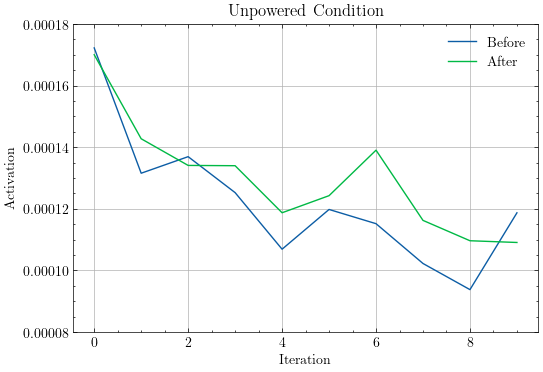

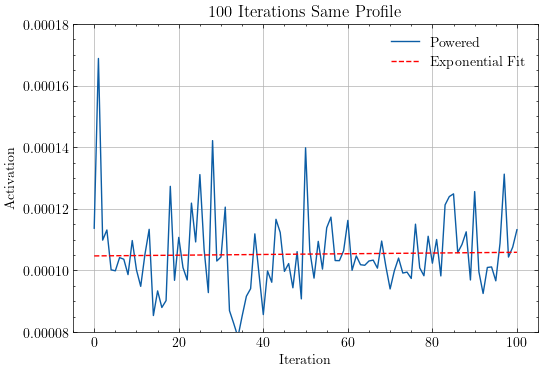

In [14]:
# plot the unpowered normalized areas

# Unpowered Plot
plt.figure(figsize=(6, 4))
plt.style.use('science')
plt.plot(unpowered_normalized_area_all["Before"], label="Before")
plt.plot(unpowered_normalized_area_all["After"], label="After")
plt.xlabel("Iteration")
plt.ylabel("Activation")
plt.ylim(0.00008, 0.00018)
plt.title("Unpowered Condition")
plt.legend()
plt.grid(True)
plt.show()

# Define exponential function
def exp_func(x, a, b):
    return a * np.exp(b * x)

# Get x (iterations) and y (data)
iterations = np.arange(len(powered_normalized_area_all))
y_data = np.array(powered_normalized_area_all)

# Fit exponential curve
popt, _ = curve_fit(exp_func, iterations, y_data, p0=(y_data[0], 0.001))  # Initial guess

# Generate fitted curve
exp_fit = exp_func(iterations, *popt)

# Plot powered data and exponential trend line
plt.figure(figsize=(6, 4))
plt.style.use('science')
plt.plot(iterations, y_data, label="Powered")
plt.plot(iterations, exp_fit, label="Exponential Fit", linestyle="--", color="red")
plt.xlabel("Iteration")
plt.ylabel("Activation")
plt.ylim(0.00008, 0.00018)
plt.title("100 Iterations Same Profile")
plt.legend()
plt.grid(True)
plt.show()


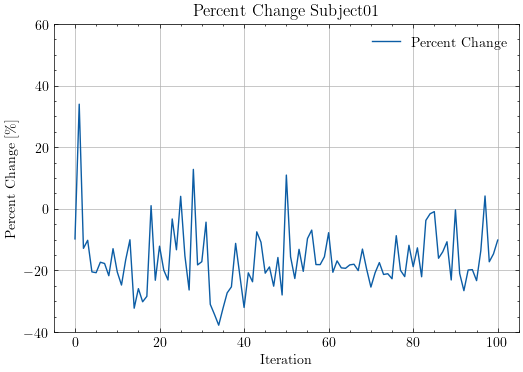

In [99]:
# Calculate mean for unpowered
mean_unpowered = np.mean(unpowered_normalized_area_all["Before"] + unpowered_normalized_area_all["After"])

# Compute percent change
percent_change = [(powered_normalized_area_all[i] - mean_unpowered) / mean_unpowered * 100 for i in range(len(powered_normalized_area_all))]

# Define exponential function
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

# Generate x values (iterations)
x_data = np.arange(len(percent_change))
y_data = np.array(percent_change)


# smooth data before fitting curve
# y_data = sp.signal.savgol_filter(y_data, 4, 1)
# Fit the curve
popt, _ = curve_fit(exp_func, x_data, y_data, p0=(1, 0.1, 1), maxfev=5000)


# Generate fitted values
y_fit = exp_func(x_data, *popt)

# Plot the percent change and the fitted curve
plt.figure(figsize=(6, 4))
plt.style.use('science')
plt.plot(x_data, y_data, label="Percent Change")
# plt.plot(x_data, y_fit, label="Exponential Fit", linestyle='--')
plt.xlabel("Iteration")
plt.ylabel("Percent Change $[\%]$")
plt.ylim(-40,60)
plt.title("Percent Change Subject01")
plt.legend()
plt.grid(True)
plt.savefig(save_path / "percent_change.png", dpi=500)
plt.show()

In [15]:
# Initialize dictionaries to store areas for each muscle
unpowered_normalized_area = {"Before": {}, "After": {}}
powered_normalized_area = {}

unpowered_extracted_emg = {"Before": [], "After": []}
powered_extracted_emg = []

# Extract muscle names (excluding the 'Time (s)' column)
muscles = list(emg_df.columns)  # Assuming first column is time

# Remove time from list
muscles.remove('Time (s)')

# Initialize lists for each muscle
for muscle in muscles:
    unpowered_normalized_area["Before"][muscle] = []
    unpowered_normalized_area["After"][muscle] = []
    powered_normalized_area[muscle] = []


# Iterate through trials
for trialnumber in [1, 2, 3]:
    trial = "Trial_" + str(trialnumber)

    # Load files
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".csv") and trial in file and "MVIC" not in file:
                file_path = os.path.join(folder_path, file)
                if "GYRO" in file:
                    gyro_path = file_path
                elif "ACC" in file:
                    acc_path = file_path
                elif "EMG" in file:
                    emg_path = file_path
                elif "OR" in file and "Debug" not in file:
                    or_path = file_path

    # Load data
    gyro_df = load_gyro(gyro_path)
    acc_df = load_acc(acc_path)
    emg_df = load(emg_path)
    or_df = load_or(or_path)

    # Drop unnecessary columns and clean data
    emg_df = emg_df.drop(columns=['EMG OR', 'EMG IMU']).dropna().reset_index(drop=True)
    emg_df, _ = filter_emg(emg_df, sfreq=2148.259)

    # Compute time intervals
    imu_time_interval = 1 / 518.519
    emg_time_interval = 1 / 2148.259
    or_time_interval = 1 / 222.22

    imu_df = pd.concat([gyro_df, acc_df], axis=1)
    imu_df['Time (s)'] = imu_df.index * imu_time_interval
    emg_df['Time (s)'] = emg_df.index * emg_time_interval
    or_df['Time (s)'] = or_df.index * or_time_interval

    # Compute segmentation
    imu_starts_time, imu_ends_time = segmentation(imu_df, emg_df, or_df, save_path)

    # Remove last start/end if needed
    if trialnumber in [1, 2]:
        imu_starts_time = imu_starts_time[:-1]
        imu_ends_time = imu_ends_time[:-1]
    elif trialnumber == 3:
        imu_starts_time = [t for t in imu_starts_time if t <= 60]
        imu_ends_time = imu_ends_time[:len(imu_starts_time)]

    # Segment and compute areas for each muscle
    for start, end in zip(imu_starts_time, imu_ends_time):
        emg_df_segmented = emg_df[(emg_df['Time (s)'] >= start) & (emg_df['Time (s)'] <= end)].reset_index(drop=True)
        emg_df_segmented['Time (s)'] = emg_df_segmented.index * emg_time_interval

        if trialnumber == 1:
            unpowered_extracted_emg["Before"].append(emg_df_segmented)
        elif trialnumber == 3:
            unpowered_extracted_emg["After"].append(emg_df_segmented)
        elif trialnumber == 2:
            powered_extracted_emg.append(emg_df_segmented)

        for muscle in muscles:
            normalized_area = np.trapz(emg_df_segmented[muscle], dx=emg_time_interval) / len(emg_df_segmented)

            if trialnumber == 1:
                unpowered_normalized_area["Before"][muscle].append(normalized_area)
            elif trialnumber == 3:
                unpowered_normalized_area["After"][muscle].append(normalized_area)
            elif trialnumber == 2:
                powered_normalized_area[muscle].append(normalized_area)


In [ ]:
# Plot all the collected emg curves

for emg_df in unpowered_extracted_emg["Before"]:
    # plot all the emg data
    for col in emg_df.columns:
        if col != "Time (s)":
            plt.plot(emg_df["Time (s)"], emg_df[col], label=col)
    plt.legend()
    plt.show()




In [39]:
#  Get MVIC
for trialnumber in [2]:
    trial = "Trial_" + str(trialnumber)

    # Load files
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".csv") and trial in file and "MVIC" in file:
                file_path = os.path.join(folder_path, file)
                if "EMG" in file:
                    emg_path = file_path

    # Load data
    emg_df = load(emg_path)

    # Drop unnecessary columns and clean data
    emg_df = emg_df.drop(columns=['EMG OR', 'EMG IMU']).dropna().reset_index(drop=True)
    emg_df, _ = filter_emg(emg_df, sfreq=2148.259)

    # Compute max
    max_values = emg_df.max()


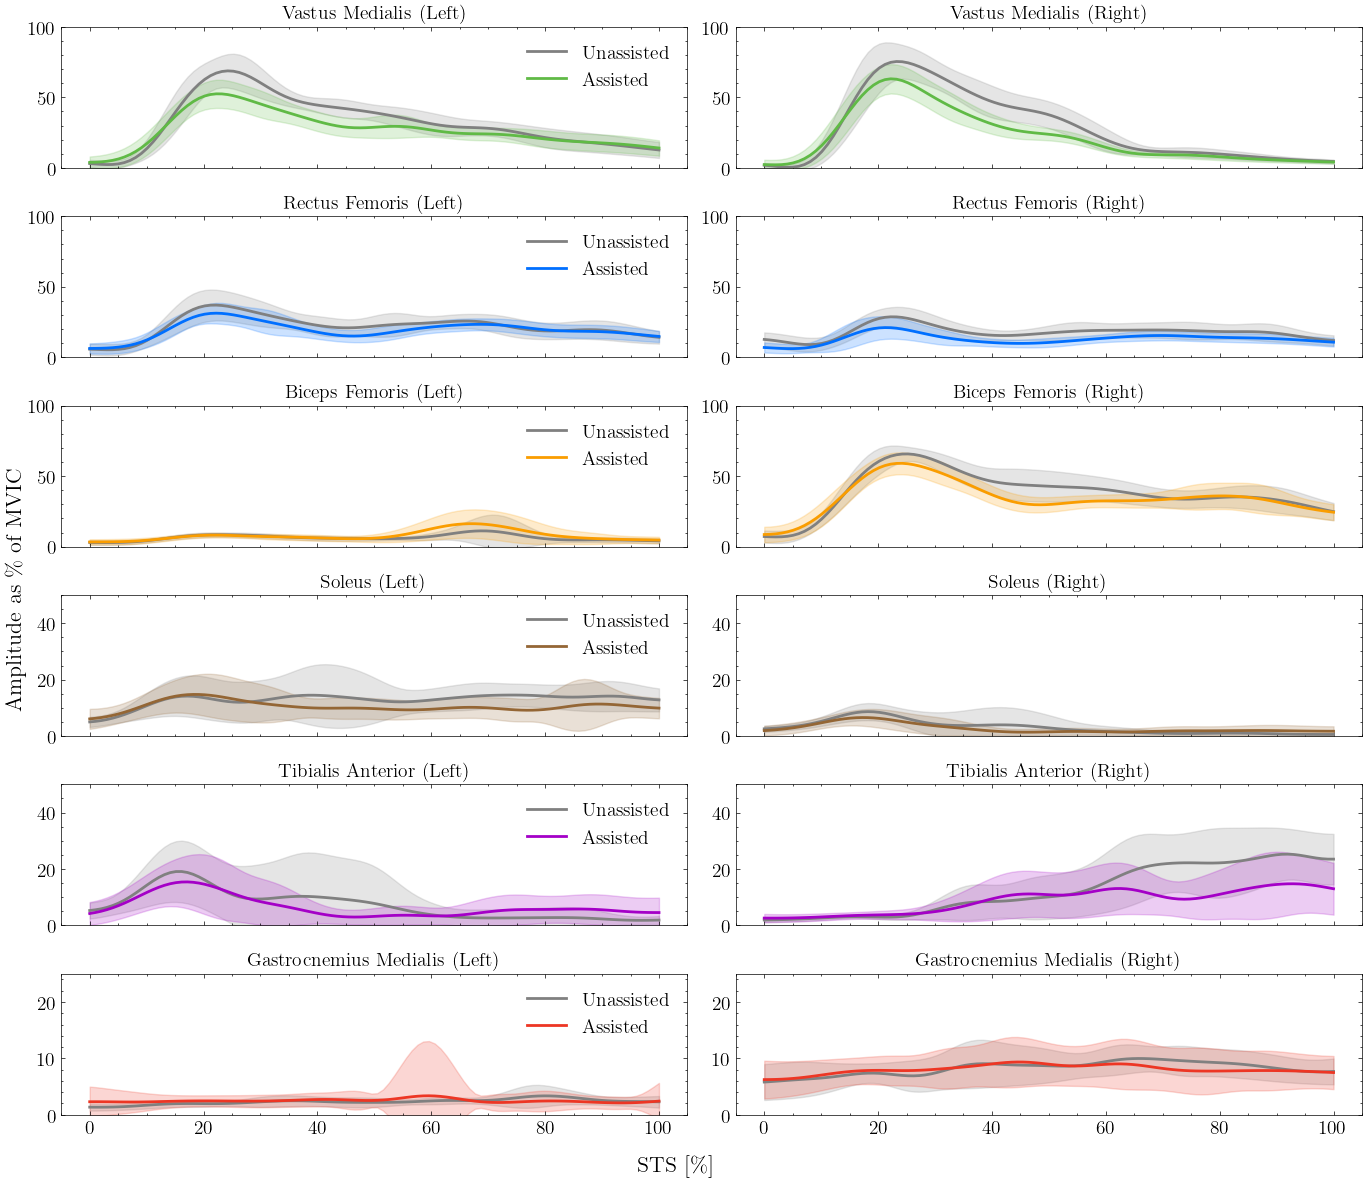

In [44]:
# Function to interpolate and normalize each segment
def interpolate_and_normalize_segments(segments, max_values, target_length=100):
    interpolated_segments = []

    for df in segments:
        df = df.drop(columns=["Time (s)"], errors="ignore")  # Drop time column if it exists
        new_index = np.linspace(0, 1, target_length)  # Normalized time axis
        interpolated_df = pd.DataFrame()

        for col in df.columns:
            x_old = np.linspace(0, 1, len(df))  # Original time axis
            
            # Normalize by max value if available
            if col in max_values:
                normalized_signal = df[col] / max_values[col]  # Scale to [0,1]
            else:
                normalized_signal = df[col]  # No scaling if max value is missing
            
            normalized_signal = normalized_signal * 100

            # Interpolate
            f = interp1d(x_old, normalized_signal, kind='linear', fill_value="extrapolate")
            interpolated_df[col] = f(new_index)  # Interpolated values

        interpolated_segments.append(interpolated_df)

    return interpolated_segments

# Function to compute mean and std across interpolated segments
def compute_mean_std(interpolated_segments):
    stacked_data = np.stack([df.values for df in interpolated_segments])  # Shape: (num_segments, target_length, num_columns)
    mean_curve = np.mean(stacked_data, axis=0)
    std_curve = np.std(stacked_data, axis=0)
    return mean_curve, std_curve, interpolated_segments[0].columns

# Function to plot left and right muscles separately for Unassisted vs. Assisted comparison
def plot_assisted_vs_unassisted(mean_unassisted, std_unassisted, mean_assisted, std_assisted, columns, title):
    muscle_full_names = {
        "VM": "Vastus Medialis",
        "RF": "Rectus Femoris",
        "BF": "Biceps Femoris",
        "SO": "Soleus",
        "TA": "Tibialis Anterior",
        "G": "Gastrocnemius Medialis",
    }
    muscles = ["VM", "RF", "BF", "SO", "TA", "G"]

    muscle_colors_hex = {
        "RF": "#006FFF",
        "VM": "#60BA46",
        "BF": "#FA9D00",
        "SO": "#946635",
        "TA": "#A400C7",
        "G": "#ED3624",
    }
    # Convert hex to RGB (0-1 scale) while keeping it in a dictionary
    muscle_colors = {muscle: mcolors.hex2color(hex_code) for muscle, hex_code in muscle_colors_hex.items()}

    muscle_pairs = {"L": [], "R": []}

    # Group muscles into left and right categories
    for col in columns:
        if "_L" in col:
            muscle_pairs["L"].append(col)
        elif "_R" in col:
            muscle_pairs["R"].append(col)

    num_pairs = max(len(muscle_pairs["L"]), len(muscle_pairs["R"]))
    fig, axes = plt.subplots(num_pairs, 2, figsize=(14, 2 * num_pairs), sharex=True)
    plt.style.use('science')

    x_axis = np.linspace(0, 100, mean_unassisted.shape[0])  # Convert to percentage scale

    # change order of muscles
    muscle_pairs["L"] = ["EMG VM_L", "EMG RF_L", "EMG BF_L", "EMG SO_L", "EMG TA_L", "EMG G_L"]
    muscle_pairs["R"] = ["EMG VM_R", "EMG RF_R", "EMG BF_R", "EMG SO_R", "EMG TA_R", "EMG G_R"]


    for i, side in enumerate(["L", "R"]):
        for j, muscle in enumerate(muscle_pairs[side]):
            ax = axes[j, i] if num_pairs > 1 else axes[i]

            idx_unassisted = columns.get_loc(muscle)
            idx_assisted = columns.get_loc(muscle)

            # get the muscle 
            muscle_name = muscle.split(" ")[1]
            side = muscle_name.split("_")[1]
            if side == "L":
                side = "Left"
            else:
                side = "Right"
            muscle_name = muscle_name.split("_")[0]

            ax.plot(x_axis, mean_unassisted[:, idx_unassisted], label="Unassisted", color="gray", linewidth=2)
            ax.fill_between(x_axis, 
                            mean_unassisted[:, idx_unassisted] - std_unassisted[:, idx_unassisted], 
                            mean_unassisted[:, idx_unassisted] + std_unassisted[:, idx_unassisted], 
                            color="gray", alpha=0.2)
            
            ax.plot(x_axis, mean_assisted[:, idx_assisted], label="Assisted", color=muscle_colors[muscle_name], linewidth=2)
            ax.fill_between(x_axis, 
                            mean_assisted[:, idx_assisted] - std_assisted[:, idx_assisted], 
                            mean_assisted[:, idx_assisted] + std_assisted[:, idx_assisted], 
                            color=muscle_colors[muscle_name], alpha=0.2)

            ax.set_title(f"{muscle_full_names[muscle_name]} ({side})", fontsize=14)
            if side == "Left":
                ax.legend(fontsize=14)

            if muscle_name in ["VM", "RF", "BF"]:
                ax.set_ylim(0, 100)
            elif muscle_name in ["G"]:
                ax.set_ylim(0, 25)
            elif muscle_name in ["TA", "SO"]:
                ax.set_ylim(0, 50)

            # change fontsize of ticks
            ax.tick_params(axis='both', which='major', labelsize=14)

    fig.supxlabel("STS $[\%]$", fontsize = 16)
    fig.supylabel("Amplitude as $\%$ of MVIC", fontsize = 16)
    # plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(save_path / "assisted_vs_unassisted.pdf", format="pdf")
    plt.show()

# Process data
target_length = 100  # Adjust as needed

# Combine Unpowered Before and After
all_unassisted_segments = unpowered_extracted_emg["Before"] + unpowered_extracted_emg["After"]
if all_unassisted_segments:
    interpolated_unassisted = interpolate_and_normalize_segments(all_unassisted_segments, max_values, target_length)
    mean_unassisted, std_unassisted, columns_unassisted = compute_mean_std(interpolated_unassisted)

if powered_extracted_emg:
    interpolated_assisted = interpolate_and_normalize_segments(powered_extracted_emg, max_values, target_length)
    mean_assisted, std_assisted, columns_assisted = compute_mean_std(interpolated_assisted)

    # Plot comparison (Assisted vs. Unassisted)
    plot_assisted_vs_unassisted(mean_unassisted, std_unassisted, mean_assisted, std_assisted, columns_unassisted, "Assisted vs. Unassisted EMG Signals (Normalized)")

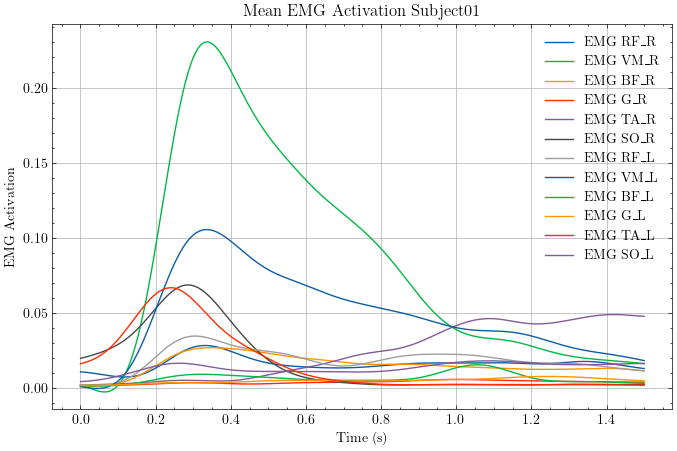

In [103]:
# Define time limit
time_limit = 1.5  # seconds

# Dictionary to store all cropped EMG data
muscle_curves = {}

# Iterate through each EMG dataframe in the dataset
for emg_df in unpowered_extracted_emg["Before"]:
    # Crop data to 1.5 seconds
    cropped_df = emg_df[emg_df["Time (s)"] <= time_limit]
    
    # Iterate through each muscle column
    for col in cropped_df.columns:
        if col != "Time (s)":
            if col not in muscle_curves:
                muscle_curves[col] = []
            muscle_curves[col].append(np.interp(
                np.linspace(0, time_limit, len(cropped_df)),  # Standardized time vector
                cropped_df["Time (s)"], 
                cropped_df[col]
            ))

# Compute mean curves for each muscle
mean_curves = {muscle: np.mean(curves, axis=0) for muscle, curves in muscle_curves.items()}

# Plot mean curves
plt.figure(figsize=(8, 5))
time_vector = np.linspace(0, time_limit, len(next(iter(mean_curves.values()))))

for muscle, mean_curve in mean_curves.items():
    plt.plot(time_vector, mean_curve, label=muscle)

plt.xlabel("Time (s)")
plt.ylabel("EMG Activation")
plt.title("Mean EMG Activation Subject01")
plt.legend()
plt.grid(True)
plt.savefig(save_path / "mean_emg_activation.png", dpi=500)
plt.show()

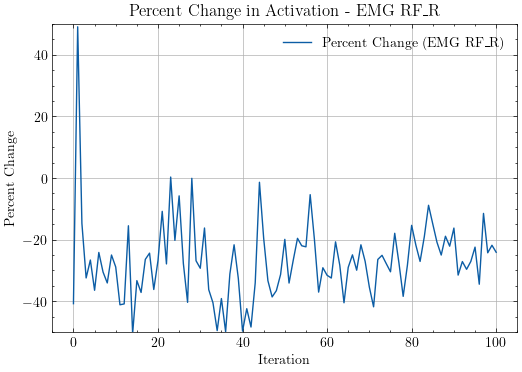

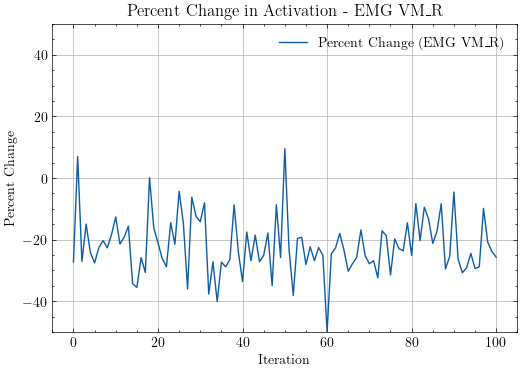

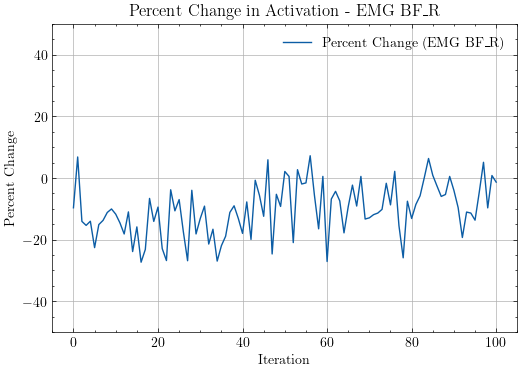

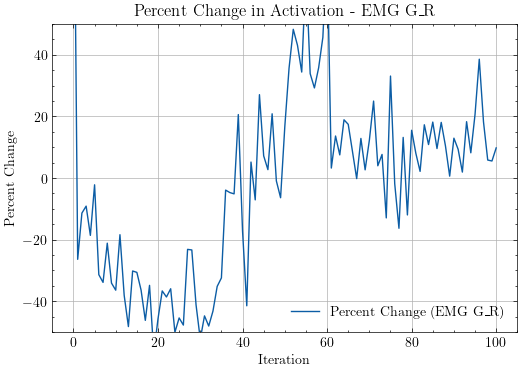

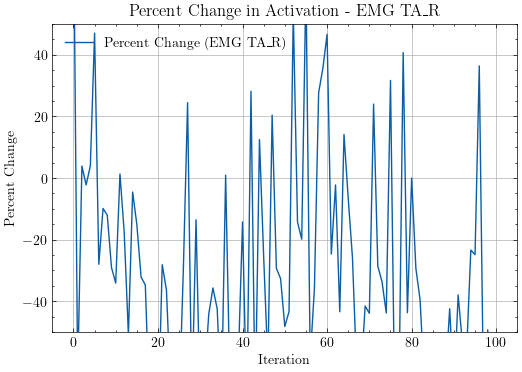

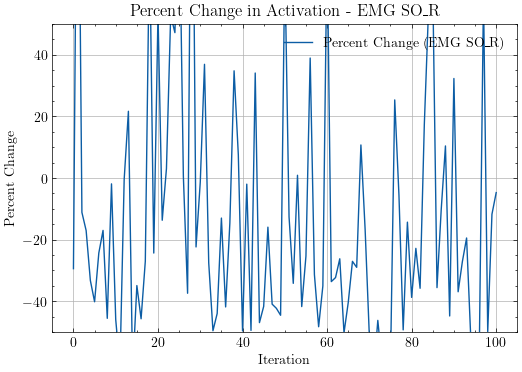

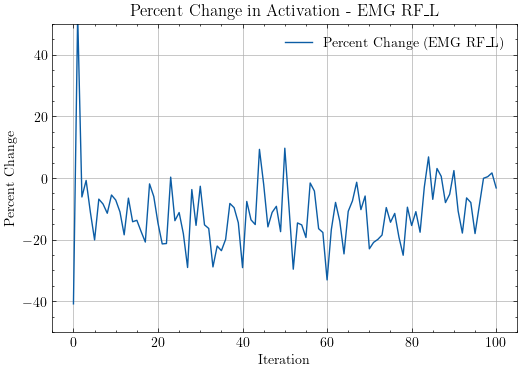

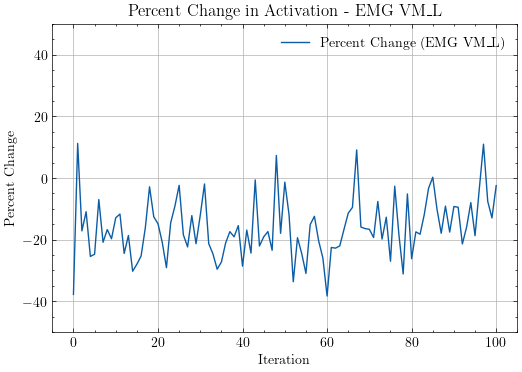

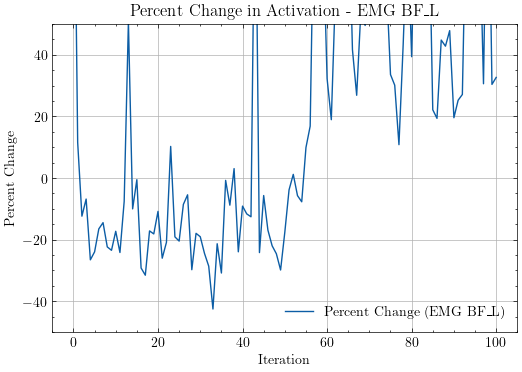

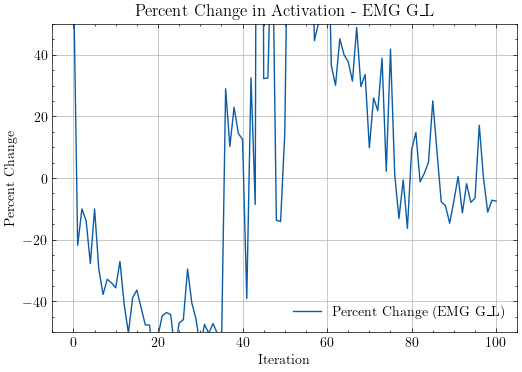

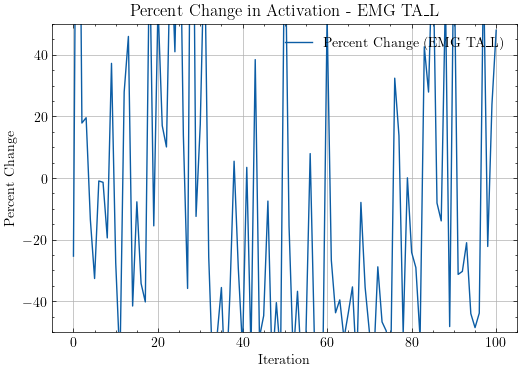

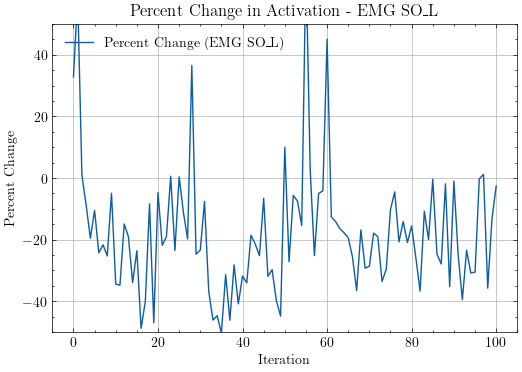

In [48]:

# Iterate over each muscle and compute percent change
for muscle in unpowered_normalized_area["Before"].keys():
    # Compute mean activation for unpowered (Before + After)
    mean_unpowered = np.mean(unpowered_normalized_area["Before"][muscle] + unpowered_normalized_area["After"][muscle])

    # Compute percent change for powered trials
    percent_change = [(val - mean_unpowered) / mean_unpowered * 100 for val in powered_normalized_area[muscle]]

    # Create plot
    plt.figure(figsize=(6, 4))
    plt.style.use('science')
    plt.plot(percent_change, label=f"Percent Change ({muscle})")
    plt.xlabel("Iteration")
    plt.ylabel("Percent Change")
    plt.ylim(-50, 50)
    plt.title(f"Percent Change in Activation - {muscle}")
    plt.legend()
    plt.grid(True)
    plt.show()


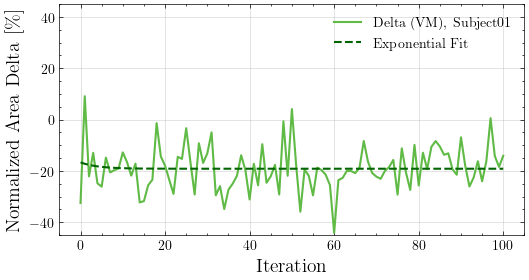

In [37]:
# Define muscle colors
muscles = ["VM", "RF", "BF", "SO", "TA", "G", "ALL"]

muscle_colors_hex = {
    "RF": "#006FFF",
    "VM": "#60BA46",
    "BF": "#FA9D00",
    "SO": "#946635",
    "TA": "#A400C7",
    "G": "#ED3624",
}
# Convert hex to RGB (0-1 scale) while keeping it in a dictionary
muscle_colors = {muscle: mcolors.hex2color(hex_code) for muscle, hex_code in muscle_colors_hex.items()}


# Compute percent change for VM
vm_percent_change = np.zeros(101)

for muscle in unpowered_normalized_area["Before"].keys():
    if "VM" in muscle:
        mean_unpowered = np.mean(unpowered_normalized_area["Before"][muscle] + unpowered_normalized_area["After"][muscle])
        vm_percent_change += [(val - mean_unpowered) / mean_unpowered * 100 for val in powered_normalized_area[muscle]]

vm_percent_change /= 2

# Define the exponential function
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

# Generate x values (iterations)
x_data = np.arange(len(vm_percent_change))
y_data = np.array(vm_percent_change)

# Provide an initial guess for the parameters
p0 = (np.max(y_data), -0.1, np.min(y_data))  # Assuming decay

# Fit the exponential curve

popt, _ = curve_fit(exp_func, x_data, y_data, p0=p0, maxfev=5000)
y_fit = exp_func(x_data, *popt)

# Plot results
plt.figure(figsize=(6, 3))
plt.style.use('science')
plt.plot(x_data, y_data, label="Delta (VM), Subject01", linestyle="-", color=muscle_colors["VM"], linewidth=1.5)
plt.plot(x_data, y_fit, label="Exponential Fit", linestyle="--", color="darkgreen", linewidth=1.5)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Normalized Area Delta $[\%]$", fontsize=14)
plt.ylim(-45, 45)
# plt.title("Percent Change in Activation - VM Subject01")
plt.legend()
plt.grid(True, alpha=0.5)
plt.savefig(save_path / "percent_change_vm01.pdf", format="pdf")
plt.show()



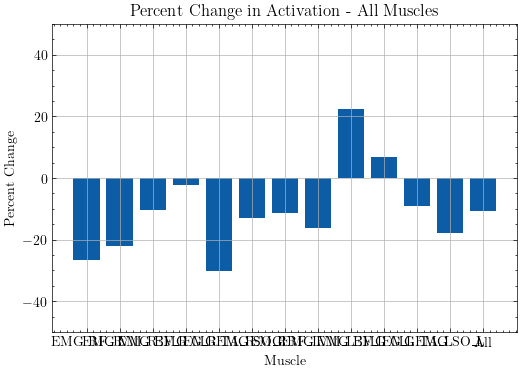

In [50]:
bars = {}

all_mean = 0
# Iterate over each muscle and compute percent change
for muscle in unpowered_normalized_area["Before"].keys():
    # Compute mean activation for unpowered (Before + After)
    mean_unpowered = np.mean(unpowered_normalized_area["Before"][muscle] + unpowered_normalized_area["After"][muscle])

    # Compute percent change for powered trials
    percent_change = [(val - mean_unpowered) / mean_unpowered * 100 for val in powered_normalized_area[muscle]]

    bars[muscle] = np.mean(percent_change)
    all_mean += np.mean(percent_change)

bars["All"] = all_mean / len(bars)

# Create plot
plt.figure(figsize=(6, 4))
plt.style.use('science')
plt.bar(bars.keys(), bars.values())
plt.xlabel("Muscle")
plt.ylabel("Percent Change")
plt.ylim(-50, 50)
plt.title(f"Percent Change in Activation - All Muscles")
plt.grid(True)
plt.show()




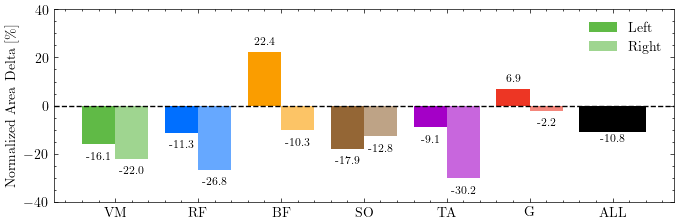

In [34]:

# Define muscle colors
muscles = ["VM", "RF", "BF", "SO", "TA", "G", "ALL"]

muscle_colors_hex = {
    "RF": "#006FFF",
    "VM": "#60BA46",
    "BF": "#FA9D00",
    "SO": "#946635",
    "TA": "#A400C7",
    "G": "#ED3624",
}
# Convert hex to RGB (0-1 scale) while keeping it in a dictionary
muscle_colors = {muscle: mcolors.hex2color(hex_code) for muscle, hex_code in muscle_colors_hex.items()}

# Add black for the "ALL" category
muscle_colors["ALL"] = "black"


# Separate left and right muscles
muscles = ["VM", "RF", "BF", "SO", "TA", "G"]
bars = {}
all_mean = 0

# Iterate over each muscle and compute percent change
for muscle in unpowered_normalized_area["Before"].keys():
    base_muscle = muscle.split(" ")[1]  # Remove "EMG"
    
    mean_unpowered = np.mean(unpowered_normalized_area["Before"][muscle] + unpowered_normalized_area["After"][muscle])
    percent_change = [(val - mean_unpowered) / mean_unpowered * 100 for val in powered_normalized_area[muscle]]

    bars[base_muscle] = np.mean(percent_change)
    all_mean += np.mean(percent_change)

bars["ALL"] = all_mean / len(bars)

# Prepare data for plotting
x_labels = []
left_values = []
right_values = []
colors = []

for muscle in muscles:
    left_muscle = f"{muscle}_L"
    right_muscle = f"{muscle}_R"

    left_values.append(bars[left_muscle])
    right_values.append(bars[right_muscle])
    x_labels.append(muscle)  # Base muscle name only
    colors.append(muscle_colors[muscle])

# Add the "ALL" category
x_labels.append("ALL")
left_values.append(bars["ALL"])
right_values.append(bars["ALL"])
colors.append(muscle_colors["ALL"])

# Plotting
x = np.arange(len(x_labels))  # X positions
width = 0.4  # Bar width

plt.figure(figsize=(8, 2.5))
bars_left = plt.bar(x - width/2, left_values, width, color=colors, label="Left")
bars_right = plt.bar(x + width/2, right_values, width, color=colors, alpha=0.6, label="Right")

# Change "ALL" alpha to 1 for both bars
bars_left[-1].set_alpha(1)
bars_right[-1].set_alpha(1)

# Add text annotations
for bar in bars_left + bars_right[:-1]:
    # for ALL bar only add the text annotation once in the middle
    if bar.get_height() == bars["ALL"]:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width(),
            height + (2 if height > 0 else -5),  # Position text above/below bar
            f"{bar.get_height():.1f}%",
            ha="center",
            va="bottom",
            fontsize=8,
        )
    else:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + (2 if height > 0 else -3),  # Position text above/below bar
            f"{height:.1f}%",
            ha="center",
            va="bottom" if height > 0 else "top",
            fontsize=8,
        )
plt.axhline(0, color="black", linestyle="dashed", linewidth=1)

# plt.xlabel("Muscles")
plt.ylabel("Normalized Area Delta $[\%]$")
plt.xticks(x, x_labels)
plt.ylim(-40, 40)
plt.legend()
# plt.grid(True, linestyle="--", alpha=0.7)
# plt.title("Percent Change in Muscle Activation Subject01")
plt.savefig(save_path / "percent_change_muscles.pdf", format="pdf")

plt.show()


### CODE TO MAKE NICE PLOTS

In [ ]:
def plot_segmented_data_nice(imu_df, emg_df, log_df, or_df, imu_starts, imu_ends, save_path):
    linewidth = 2
    fontsize = 14

    color_values = np.linspace(0.0, 0.6, 8)  # Higher subplot -> Higher colormap value
    colors = [cm.plasma(value) for value in color_values]

    # invert order of colors
    # colors = colors[::-1]

    # filter imu data
    imu_df = apply_lowpass_filter(imu_df, 1, 519)

    # Plotting
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 6), sharex=True)
    plt.style.use('science')

    # Subplot for angular accelerations (ACC X, ACC Y, ACC Z)
    ax1.plot(imu_df['Time (s)'], imu_df['ACC X (G)'], label='ACC X', linewidth=linewidth, color=colors[0], alpha=0.5)
    ax1.plot(imu_df['Time (s)'], imu_df['ACC Y (G)'], label='ACC Y', linewidth=linewidth, color=colors[1], alpha=0.5)
    ax1.plot(imu_df['Time (s)'], imu_df['ACC Z (G)'], label='ACC Z', linewidth=linewidth, color=colors[2])
    ax1.set_ylabel('Acceleration\n$[deg/s^2]$', fontsize=fontsize)
    ax1.set_ylim(-1.8, 1.5)
    # ax1.set_title('Angular Accelerations')
    ax1.legend(fontsize=fontsize)
    # ax1.grid(True)

    # Subplot for angular velocities (GYRO X, GYRO Y, GYRO Z)
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO X (deg/s)'], label='GYRO X', linewidth=linewidth, color=colors[3])
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO Y (deg/s)'], label='GYRO Y', linewidth=linewidth, color=colors[4], alpha=0.5)
    ax2.plot(imu_df['Time (s)'], imu_df['GYRO Z (deg/s)'], label='GYRO Z', linewidth=linewidth, color=colors[5], alpha=0.5)
    # ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Velocity\n$[deg/s]$', fontsize=fontsize)
    ax2.set_ylim(-180, 120)
    # ax2.set_title('Angular Velocities')
    ax2.legend(fontsize=fontsize+5)
    # ax2.grid(True)

    # Subplot for roll angle
    ax3.plot(or_df['Time (s)'], or_df['roll_angle'], label='Roll Angle', linewidth=linewidth, color=colors[6])
    ax3.set_ylabel('Roll Angle\n$[rad]$', fontsize=fontsize)
    ax3.set_ylim(-0.2, 1.6)
    # ax3.set_title('Roll Angle')
    # ax3.legend(fontsize=fontsize)
    # ax3.grid(True)

    # Subplot for EMG data
    ax4.plot(emg_df['Time (s)'], emg_df['EMG VM_R'], label='EMG', linewidth=linewidth+1, color="orchid")
    ax4.set_xlabel('Time $[s]$', fontsize=fontsize)
    ax4.set_ylabel('EMG\n$[mV]$', fontsize=fontsize)
    # ax4.set_title('EMG Data')
    # ax4.legend(fontsize=fontsize)
    # ax4.grid(True)

    # remove x ticks
    ax1.set_xticks([])
    ax2.set_xticks([])
    ax3.set_xticks([])
    ax4.set_xticks([])

    # remove y ticks
    ax1.set_yticks([])
    ax2.set_yticks([])
    ax3.set_yticks([])
    ax4.set_yticks([])

    # move legends to bottom right
    ax1.legend(loc='lower right', bbox_to_anchor=(1.04, 0))
    ax2.legend(loc='lower right', bbox_to_anchor=(1.04, 0))
    # ax3.legend(loc='upper right')
    # ax4.legend(loc='upper right')

    # Remove right and top wall
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)

    # make other walls thicker
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    ax2.spines['left'].set_linewidth(2)
    ax2.spines['bottom'].set_linewidth(2)
    ax3.spines['left'].set_linewidth(2)
    ax3.spines['bottom'].set_linewidth(2)
    ax4.spines['left'].set_linewidth(2)
    ax4.spines['bottom'].set_linewidth(2)



    # Add vertical lines for each segment start and end from log_df
    for i in range(len(imu_starts)):
        start = imu_starts[i]
        end = imu_ends[i]

        start_alpha = 0.3
        end_alpha = 0.7

        # Same color for both start and end in each column
        start_color = 'black'
        end_color = 'black'

        # Plot on all axes
        ax1.axvline(x=start, color=start_color, linestyle='--', label='Start' if i == 0 else "", linewidth=linewidth, alpha=start_alpha)
        ax1.axvline(x=end, color=end_color, linestyle='--', label='End' if i == 0 else "", linewidth=linewidth, alpha=end_alpha)
        if i == 0:
            ax1.annotate('',
                xy=(start, 1.5), 
                xytext=(end, 1.5), 
                arrowprops=dict(arrowstyle='<->', color='black', linewidth=1.5),
                ha='center', va='bottom', fontsize=12, fontweight='bold'
            )
            ax1.text((start+end)/2, 1.6, 'Sit-to-Stand', ha='center', va='bottom', fontsize=12, fontweight='bold')

        ax2.axvline(x=start, color=start_color, linestyle='--', label='Start' if i == 0 else "", linewidth=linewidth, alpha=start_alpha)
        ax2.axvline(x=end, color=end_color, linestyle='--', label='End' if i == 0 else "", linewidth=linewidth, alpha=end_alpha)

        ax3.axvline(x=start, color=start_color, linestyle='--', label='Start' if i == 0 else "", linewidth=linewidth, alpha=start_alpha)
        ax3.axvline(x=end, color=end_color, linestyle='--', label='End' if i == 0 else "", linewidth=linewidth, alpha=end_alpha)
        # if i == 0:
        #     ax3.legend(fontsize=fontsize)

        ax4.axvline(x=start, color=start_color, linestyle='--', label='Start' if i == 0 else "", linewidth=linewidth, alpha=start_alpha)
        ax4.axvline(x=end, color=end_color, linestyle='--', label='End' if i == 0 else "", linewidth=linewidth, alpha=end_alpha)

    # Show plot
    plt.tight_layout()

    # save the plot as a file
    filename = save_path / 'segmented_data.png'
    plt.savefig(filename, dpi=500)  # Save with specified resolution
